Found 2224 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 479 images belonging to 2 classes.
Epoch 1/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.6951 - loss: 0.5936 - val_accuracy: 0.8571 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 2/18
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - accuracy: 0.8750 - loss: 0.3029

C:\Users\kavit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 809ms/step - accuracy: 0.8750 - loss: 0.3029 - val_accuracy: 0.8728 - val_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 3/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 328s 5s/step - accuracy: 0.8520 - loss: 0.3315 - val_accuracy: 0.8259 - val_loss: 0.3346 - learning_rate: 1.0000e-04
Epoch 4/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 808ms/step - accuracy: 0.8125 - loss: 0.3239 - val_accuracy: 0.8415 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 5/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.8931 - loss: 0.2389 - val_accuracy: 0.9107 - val_loss: 0.2388 - learning_rate: 1.0000e-04
Epoch 6/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 834ms/step - accuracy: 0.9688 - loss: 0.1594 - val_accuracy: 0.9062 - val_loss: 0.2425 - learning_rate: 1.0000e-04
Epoch 7/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.9156 - loss: 0.2118 - val_accuracy: 0.9174 - val_loss: 0.2237 - learning_rate: 1.0000e-04
Epoch 8/18
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 845ms/step - accuracy: 0.9688 - l

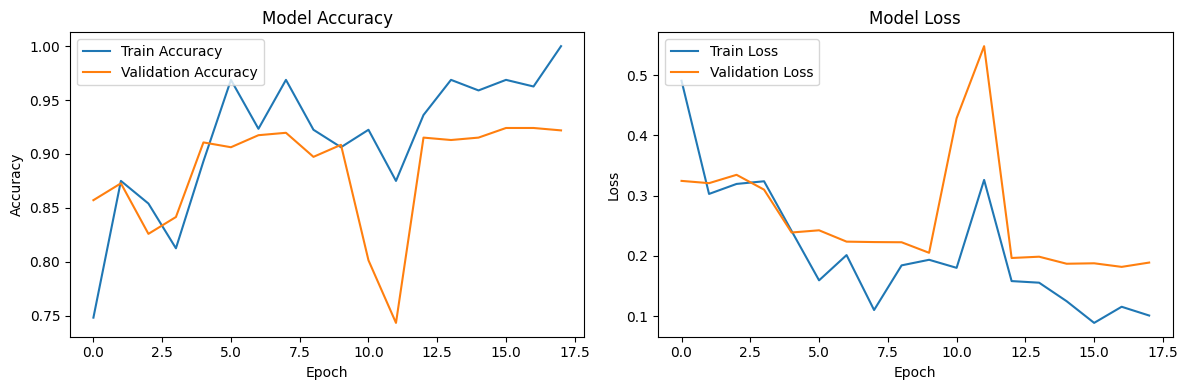

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define paths
base_dir = './images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)
validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 (VGG19 input size)
    batch_size=32,
    class_mode='binary'  # Binary classification (healthy/unhealthy)
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle for evaluation
)

# Load the VGG19 model (pre-trained on ImageNet)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (do not train the pre-trained layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the output of the base model
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks: Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=18,  # Increase epochs since early stopping will prevent overfitting
    callbacks=[early_stopping, reduce_lr]  # Add callbacks here
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.4f}')

# Predictions on the test set
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Classification report and confusion matrix
print('Classification Report:')
print(classification_report(test_generator.classes, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(test_generator.classes, y_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()